# Demo code for Ito et al., 2017.
### Network-level information estiamtes. Replicates figures from supplementary figure 1b

####  Last updated: 07/16/2017
**Summary:** 

Reads in preprocessed, empirical data. For each subject, we provide miniblock activation estimates (obtained from a beta series regression for every region in the Glasser et al. (2016) atlas). We also provide task-rule condition labels for each miniblock (e.g., miniblock 1 is associated with the logic rule "both").

For each subject, we estimate the network-level information estimate using a cross-validated representational similarity analysis, as described in the manuscript.

We then compute group statistics to obtain the panels for Supplementary Figure 1b.

See Supplemental materials/methods for a full description.

In [49]:
import sys
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp as mc
import multiprocessing as mp
%matplotlib inline
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import warnings
warnings.filterwarnings('ignore')
import pandas 
import networkinformationtransfer as n2n
from IPython.display import display, HTML


# 0.0 Basic parameters

In [5]:
# Set basic parameters
datadir = './data/'
runLength = 4648
subjNums = ['032', '033', '037', '038', '039', '045', 
            '013', '014', '016', '017', '018', '021', 
            '023', '024', '025', '026', '027', '031', 
            '035', '046', '042', '028', '048', '053', 
            '040', '049', '057', '062', '050', '030', '047', '034']

# Load in network array
networkdef = np.loadtxt(datadir + 'network_array.csv', delimiter=',')


# Load in network keys (each network associated with a number in network array)
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud1':8, 'aud2':9, 'dan':11}
# Force aud2 key to be the same as aud1 (merging two auditory networks)
aud2_ind = np.where(networkdef==networkmappings['aud2'])[0]
networkdef[aud2_ind] = networkmappings['aud1']
# Redefine new network mappings with no aud1/aud2 distinction
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'dan':11}

#### Set up basic functions

In [40]:
def loadBetas(subj, net='all'):
    """Loads in task betas"""
    datafile = datadir + 'MiniblockActivations/' + subj + '_miniblock_taskBetas_Glasser.csv'
    betas = np.loadtxt(datafile, delimiter=',')
    betas = betas[:,17:]
    if net == 'all':
        return betas
    else:
        net_ind = np.where(networkdef==net)[0]
        return betas[net_ind,:].T
    
def setupMatrix(subj,ruledim,net):
    """
    Sets up basic SVM Matrix for a classification of a particular rule dimension and network
    """
    
    svm_mat = loadBetas(subj,net=net)
    # Subtract miniblock indices by 1, since they were originally created for Matlab array indices
    labels = np.loadtxt('./data/CPROTaskIdentifiers/' + subj + '_' + ruledim + '_miniblocksPerRule_MatlabIndices.csv',delimiter=',') - 1 
            
    labels = np.asarray(labels,dtype=int)
    
    return svm_mat, labels



# Set up functions for RSA analysis (instead of SVM decoding)

In [34]:
def rsaCV(svm_mat,labels,ruledim):
    """Runs a leave-4-out CV for a 4 way  classification"""
        
    # 32 folds, if we do a leave 4 out for 128 total miniblocks
    # Want to leave a single block from each rule from each CV
    # labels is a sample x rule matrix, so 32 samples x 4 rules
    
    # Number of CVs is columns
    ncvs = labels.shape[0]
    nrules = labels.shape[1]
    corr_rho_cvs = []
    err_rho_cvs = []
    for cv in range(ncvs):
        # Select a test set from the CV Fold matrix
        test_ind = labels[cv,:].copy()
        # Delete the CV included from the train set
        train_ind = np.delete(labels,cv,axis=0)
        
        # Identify the train and test sets
        svm_train = svm_mat[np.reshape(train_ind,-1),:]
        svm_test = svm_mat[test_ind,:]
        
        prototype = {}
        # Construct RSA prototypes
        for rule in range(nrules):
            prototype_ind = np.reshape(train_ind[:,rule],-1)
            prototype[rule] = np.mean(svm_mat[prototype_ind],axis=0)
            
        corr_rho = []
        err_rho = []
        for rule1 in range(nrules):
            for rule2 in range(nrules):
                r = stats.spearmanr(prototype[rule1],svm_test[rule2,:])[0]
                r = np.arctanh(r)
                if rule1==rule2: 
                    corr_rho.append(r)
                else:
                    err_rho.append(r)
        
        corr_rho_cvs.append(np.mean(corr_rho))
        err_rho_cvs.append(np.mean(err_rho))

        

    return np.mean(corr_rho_cvs), np.mean(err_rho_cvs)
        
    
def subjRSACV((subj,ruledim,net)):
    svm_mat, labels = setupMatrix(subj,ruledim,net)
    # Demean each sample
    svmmean = np.mean(svm_mat,axis=1)
    svmmean.shape = (len(svmmean),1)
    svm_mat = svm_mat - svmmean
    
#     svm_mat = preprocessing.scale(svm_mat,axis=0)
    
    corr_rho, err_rho = rsaCV(svm_mat, labels, ruledim)
    diff_rho = corr_rho - err_rho

    return corr_rho, err_rho, diff_rho


In [30]:
netkeys = {0:'fpn', 1:'dan', 2:'con', 3:'dmn', 4:'vis', 5:'aud', 6:'smn'}

In [44]:
ruledims = ['logic','sensory','motor']
corr_rho = {}
err_rho = {}
diff_rho = {}
avg_acc = {}
for ruledim in ruledims:
    avg_acc[ruledim] = {}
    corr_rho[ruledim] = np.zeros((len(netkeys),len(subjNums)))
    err_rho[ruledim] = np.zeros((len(netkeys),len(subjNums)))
    diff_rho[ruledim] = np.zeros((len(netkeys),len(subjNums)))
    print 'Running', ruledim
    for net in netkeys.keys():
#         print 'Running network', net
        inputs = []
        for subj in subjNums: inputs.append((subj,ruledim,networkmappings[netkeys[net]]))
            
        pool = mp.Pool(processes=3)
        results = pool.map_async(subjRSACV,inputs).get()
        pool.close()
        pool.join()
        
        scount = 0
        for result in results:
            tmp_corr, tmp_err, tmp_diff = result
            corr_rho[ruledim][net,scount] = tmp_corr
            err_rho[ruledim][net,scount] = tmp_err
            diff_rho[ruledim][net,scount] = tmp_diff
            scount += 1
        avg_acc[ruledim][net] = np.mean(diff_rho[ruledim][net])



Running logic
Running sensory
Running motor


## Run statistics with FDR-correction

In [45]:
# Compute group stats
chance = 0.0
results_dict_fdr = {}
for ruledim in ruledims:
    results_dict_fdr[ruledim] = {}
    for net in netkeys.keys(): results_dict_fdr[ruledim][netkeys[net]] = {}
    pvals = []
    for net in netkeys.keys():
        results_dict_fdr[ruledim][netkeys[net]]['Accuracy'] = str(round(np.mean(avg_acc[ruledim][net]),3))
        t, p = stats.ttest_1samp(diff_rho[ruledim][net],chance)
        results_dict_fdr[ruledim][netkeys[net]]['T-stats'] = t
        results_dict_fdr[ruledim][netkeys[net]]['P-values'] = p
        pvals.append(p)
        
    qvals = mc.fdrcorrection0(pvals)[1]
    qcount = 0
    for net in netkeys.keys():
        results_dict_fdr[ruledim][netkeys[net]]['Q-values'] = qvals[qcount]
        qcount += 1

#### Show results as dataframe

In [50]:
results_dframe_fdr = {}
for ruledim in ruledims:
    print 'Dataframe for', ruledim, 'classification'
    results_dframe_fdr[ruledim] = pandas.DataFrame(data=results_dict_fdr[ruledim])
    display(results_dframe_fdr[ruledim])

Dataframe for logic classification


,aud,con,dan,dmn,fpn,smn,vis
Accuracy,0.019,0.029,0.024,0.029,0.034,0.007,0.015
P-values,0.0007204865,1.958453e-06,0.0003274894,2.174088e-06,1.539976e-07,0.23322,0.003173029
Q-values,0.001008681,5.072872e-06,0.0005731065,5.072872e-06,1.077983e-06,0.23322,0.003701867
T-stats,3.753809,5.835957,4.039269,5.799369,6.736163,1.21585,3.199006


Dataframe for sensory classification


,aud,con,dan,dmn,fpn,smn,vis
Accuracy,0.004,0.012,0.024,0.01,0.025,-0.004,0.054
P-values,0.1553106,0.0002267056,4.158905e-07,0.03745678,0.000257061,0.2592903,1.789729e-06
Q-values,0.1811957,0.0004498568,2.911233e-06,0.05243949,0.0004498568,0.2592903,6.264051e-06
T-stats,1.456495,4.170853,6.381915,2.174047,4.125994,-1.149133,5.867531


Dataframe for motor classification


,aud,con,dan,dmn,fpn,smn,vis
Accuracy,0.007,0.017,0.017,0.009,0.004,0.203,0.005
P-values,0.02081302,2.192417e-05,9.094485e-06,0.03528071,0.2254022,1.040003e-12,0.07712767
Q-values,0.03642278,5.115639e-05,3.18307e-05,0.04939299,0.2254022,7.28002e-12,0.08998228
T-stats,2.435596,4.992822,5.299654,2.20139,1.236929,11.49508,1.828394


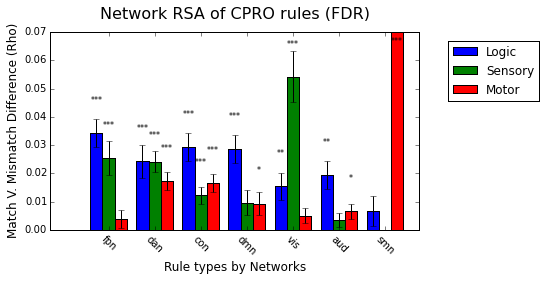

In [51]:
#### Compute statistics for bar plot
bar_avgs = {}
bar_sems = {}
bar_avg_all = {}
for net in netkeys.keys(): bar_avg_all[net] = np.zeros((len(ruledims),len(subjNums)))

rulecount = 0
for ruledim in ruledims:
    bar_avgs[ruledim] = {}
    bar_sems[ruledim] = {}
    for net in netkeys.keys():
        bar_avgs[ruledim][net] = np.mean(diff_rho[ruledim][net])
        bar_sems[ruledim][net] = np.std(diff_rho[ruledim][net])/np.sqrt(len(subjNums))
        bar_avg_all[net][rulecount,:] = diff_rho[ruledim][net]
    rulecount += 1
        
bar_sem_all = {}
for net in netkeys.keys():
    meanacc = np.mean(bar_avg_all[net],axis=0)
    bar_avg_all[net] = np.mean(meanacc)
    bar_sem_all[net] = np.std(meanacc)/np.sqrt(len(subjNums))

##### Generate figures
width=0.25
width=.265
networks = netkeys.keys()
nbars = len(networks)
fig = plt.figure()
ax = fig.add_subplot(111)
rects = {}
widthcount = 0
colors = ['b','g','r']
colorcount = 0
for ruledim in ruledims:
    rects[ruledim] = ax.bar(np.arange(nbars)+widthcount, bar_avgs[ruledim].values(), width,align='center',
                     yerr=bar_sems[ruledim].values(), color=colors[colorcount], error_kw=dict(ecolor='black'))
    widthcount += width
    colorcount += 1
    
ax.set_title('Network RSA of CPRO rules (FDR)',
             y=1.04, fontsize=16)
ax.set_ylabel('Match V. Mismatch Difference (Rho)',fontsize=12)
ax.set_xlabel('Rule types by Networks', fontsize=12)
ax.set_xticks(np.arange(nbars)+width)
ax.set_xticklabels(netkeys.values(),rotation=-45)
vmax=0.07
ax.set_ylim([0,vmax])

plt.legend((rects['logic'], rects['sensory'], rects['motor']),
           ('Logic', 'Sensory', 'Motor'), loc=((1.08,.65)))

## Add asterisks
def autolabel(rects,df,ruledim):
    # attach some text labels
    netcount = 0
    for rect in rects:
        height = rect.get_height()
        # Decide where to put the asterisk
        if height > vmax: 
            yax = vmax - .005
        else:
            yax = height + .01
            
        # Slightly move this asterisk since it's in the way
        if ruledim=='sensory' and netkeys[netcount]=='dan': yax -= .0025
            
        # Retrive q-value and assign asterisk accordingly
        q = df[netkeys[netcount]]['Q-values']
        if q > .05: asterisk=''
        if q < .05: asterisk='*'
        if q < .01: asterisk='**'
        if q < .001: asterisk='***'
            
        # Label bar
        ax.text(rect.get_x() + rect.get_width()/2., yax,
                asterisk, ha='center', va='bottom', fontsize=8)
        # Go to next network
        netcount += 1
        
for ruledim in ruledims:
    autolabel(rects[ruledim],results_dframe_fdr[ruledim],ruledim)
# autolabel(rects2)

plt.tight_layout()
# plt.savefig('FigS1a_NetworkRSA_InformationEstimate.pdf')


# Run statistics with FWER-correction (Permutation testing)
#### Need to download the Multiple Comparisons toolbox and add it to the correct path

In [59]:
import sys
pathToFWEPackage = '../../'
sys.path.append(pathToFWEPackage + 'MultipleComparisonsPermutationTesting/pythonCode/')
import permutationTesting as pt
# Compute group stats
chance = 0.0
results_dict_fwe = {}
for ruledim in ruledims:
    results_dict_fwe[ruledim] = {}
    for net in netkeys.keys(): results_dict_fwe[ruledim][netkeys[net]] = {}
    pvals = []
    for net in netkeys.keys():
        results_dict_fwe[ruledim][netkeys[net]]['Accuracy'] = str(round(np.mean(avg_acc[ruledim][net]),3))
        t, maxT, p = pt.maxT(diff_rho[ruledim],nullmean=0,permutations=10000,nproc=3,pvals=True)
#         t, p = stats.ttest_1samp(diff_rho[ruledim][net],chance)
        results_dict_fwe[ruledim][netkeys[net]]['T-stats'] = t[net]
        results_dict_fwe[ruledim][netkeys[net]]['Q-values'] = p[net]
        

#### Show results as dataframe

In [60]:
results_dframe_fwe = {}
for ruledim in ruledims:
    print 'Dataframe for', ruledim, 'classification'
    results_dframe_fwe[ruledim] = pandas.DataFrame(data=results_dict_fwe[ruledim])
    display(results_dframe_fwe[ruledim])

Dataframe for logic classification


,aud,con,dan,dmn,fpn,smn,vis
Accuracy,0.019,0.029,0.024,0.029,0.034,0.007,0.015
Q-values,0.0027,0,0.0008,0,0,0.5783,0.0098
T-stats,3.753809,5.835957,4.039269,5.799369,6.736163,1.21585,3.199006


Dataframe for sensory classification


,aud,con,dan,dmn,fpn,smn,vis
Accuracy,0.004,0.012,0.024,0.01,0.025,-0.004,0.054
Q-values,0.4295,0.0004,0,0.108,0.0003,1,0
T-stats,1.456495,4.170853,6.381915,2.174047,4.125994,-1.149133,5.867531


Dataframe for motor classification


,aud,con,dan,dmn,fpn,smn,vis
Accuracy,0.007,0.017,0.017,0.009,0.004,0.203,0.005
Q-values,0.0698,0,0,0.1123,0.5589,0,0.2456
T-stats,2.435596,4.992822,5.299654,2.20139,1.236929,11.49508,1.828394


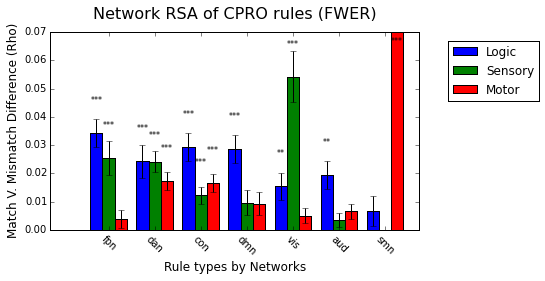

In [61]:
#### Compute statistics for bar plot
bar_avgs = {}
bar_sems = {}
bar_avg_all = {}
for net in netkeys.keys(): bar_avg_all[net] = np.zeros((len(ruledims),len(subjNums)))

rulecount = 0
for ruledim in ruledims:
    bar_avgs[ruledim] = {}
    bar_sems[ruledim] = {}
    for net in netkeys.keys():
        bar_avgs[ruledim][net] = np.mean(diff_rho[ruledim][net])
        bar_sems[ruledim][net] = np.std(diff_rho[ruledim][net])/np.sqrt(len(subjNums))
        bar_avg_all[net][rulecount,:] = diff_rho[ruledim][net]
    rulecount += 1
        
bar_sem_all = {}
for net in netkeys.keys():
    meanacc = np.mean(bar_avg_all[net],axis=0)
    bar_avg_all[net] = np.mean(meanacc)
    bar_sem_all[net] = np.std(meanacc)/np.sqrt(len(subjNums))

##### Generate figures
width=0.25
width=.265
networks = netkeys.keys()
nbars = len(networks)
fig = plt.figure()
ax = fig.add_subplot(111)
rects = {}
widthcount = 0
colors = ['b','g','r']
colorcount = 0
for ruledim in ruledims:
    rects[ruledim] = ax.bar(np.arange(nbars)+widthcount, bar_avgs[ruledim].values(), width,align='center',
                     yerr=bar_sems[ruledim].values(), color=colors[colorcount], error_kw=dict(ecolor='black'))
    widthcount += width
    colorcount += 1
    
ax.set_title('Network RSA of CPRO rules (FWER)',
             y=1.04, fontsize=16)
ax.set_ylabel('Match V. Mismatch Difference (Rho)',fontsize=12)
ax.set_xlabel('Rule types by Networks', fontsize=12)
ax.set_xticks(np.arange(nbars)+width)
ax.set_xticklabels(netkeys.values(),rotation=-45)
vmax=0.07
ax.set_ylim([0,vmax])

plt.legend((rects['logic'], rects['sensory'], rects['motor']),
           ('Logic', 'Sensory', 'Motor'), loc=((1.08,.65)))

## Add asterisks
def autolabel(rects,df,ruledim):
    # attach some text labels
    netcount = 0
    for rect in rects:
        height = rect.get_height()
        # Decide where to put the asterisk
        if height > vmax: 
            yax = vmax - .005
        else:
            yax = height + .01
            
        # Slightly move this asterisk since it's in the way
        if ruledim=='sensory' and netkeys[netcount]=='dan': yax -= .0025
            
        # Retrive q-value and assign asterisk accordingly
        q = df[netkeys[netcount]]['Q-values']
        if q > .05: asterisk=''
        if q < .05: asterisk='*'
        if q < .01: asterisk='**'
        if q < .001: asterisk='***'
            
        # Label bar
        ax.text(rect.get_x() + rect.get_width()/2., yax,
                asterisk, ha='center', va='bottom', fontsize=8)
        # Go to next network
        netcount += 1
        
for ruledim in ruledims:
    autolabel(rects[ruledim],results_dframe_fwe[ruledim],ruledim)
# autolabel(rects2)

plt.tight_layout()
# plt.savefig('FigS1a_NetworkRSA_InformationEstimate.pdf')
